# The Theory Behind LightGBM

Before we run the code, we must understand how LightGBM is different from other gradient boosting models (like XGBoost or standard GBDT). LightGBM is designed for speed and efficiency. It achieves this through two main innovations that make it "Light".

1. Leaf-Wise Growth (The Structure)
Most traditional boosting algorithms (like XGBoost) grow trees level-wise (depth-first). They split every leaf at a certain depth before moving to the next.

   *    LightGBM grows leaf-wise (best-first). It chooses the single leaf with the highest "delta loss" (the split that reduces the error the most) and splits it.

   *    Result: This leads to deeper, more complex trees that converge faster but can overfit on small datasets if not controlled.

2. GOSS (Gradient-based One-Side Sampling)
This is how LightGBM selects which data rows to learn from.

   *    The Problem: Traditional GBDT scans all data instances to find the best split.

    *    The Solution: GOSS keeps all data instances with large gradients (large errors) and randomly samples only a percentage of instances with small gradients (small errors).

     *   Why? Instances with large errors teach the model more. This drastically reduces calculation time with minimal accuracy loss.

3. EFB (Exclusive Feature Bundling)
This is how LightGBM handles features (columns).

    *    The Idea: In sparse datasets (lots of zeros), many features never appear together (they are mutually exclusive). LightGBM bundles these features into a single feature using a histogram approach.

    *   Result: It reduces the number of features the model has to scan, speeding up training.

# Basic Implementation

In [1]:
# !pip install lightgbm scikit-learn pandas numpy matplotlib

import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Load Data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# 2. Split Data (Always split before doing anything else)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize the Model
# We use the sklearn API of LightGBM which is easier for beginners
clf = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    boosting_type='gbdt',
    num_leaves=31,       # Default is 31
    learning_rate=0.05,  # Slightly lower learning rate for better generalization
    feature_fraction=0.9 # Use 90% of features per tree to prevent overfitting
)

# 4. Train the Model
clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='logloss'
)

# 5. Predict & Evaluate
y_pred = clf.predict(X_test)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 286, number of negative: 169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4548
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628571 -> initscore=0.526093
[LightGBM] [Info] Start training fr

# Key Hyperparameters Explained

### LightGBM Hyperparameter Tuning Guide

| Parameter | What it does | Impact on Bias/Variance |
| :--- | :--- | :--- |
| **num_leaves** | **Most Important.** Controls the complexity of the tree. Since LGBM is leaf-wise, this controls depth implicitly. | High value = Low Bias, High Variance (Overfitting). |
| **min_data_in_leaf** | The minimum samples required to create a leaf. | High value = High Bias, Low Variance (Prevents overfitting). |
| **max_depth** | Limits how deep the tree can grow. | Used to limit overfitting if `num_leaves` is high. |
| **learning_rate** | The "step size" the model takes. Small rate requires more `n_estimators`. | Low rate = Better accuracy, slower training. |
| **n_estimators** | Number of boosting rounds (trees). | Too high = Overfitting. |
| **bagging_fraction** | Randomly selects a subset of data for each iteration (e.g., 0.8 = 80%). | Increases speed, decreases overfitting. |
| **feature_fraction** | Randomly selects a subset of features for each tree. | Prevents model from relying too much on one feature. |


# Advanced Pipeline & Hyperparameter Tuning

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, KFold

# 1. Load a Regression Dataset
housing = fetch_california_housing()
X_reg = pd.DataFrame(housing.data, columns=housing.feature_names)
y_reg = pd.Series(housing.target)

# 2. Define our Pipeline
# Note: LightGBM does not strictly NEED scaling, but in a pipeline
# with other potential steps (like PCA or linear features), it's good practice.
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lgbm', lgb.LGBMRegressor(random_state=42, verbose=-1))
])

# 3. Define the Parameter Grid
# Notice the 'lgbm__' prefix? That tells the pipeline to apply these params to the 'lgbm' step.
param_dist = {
    'lgbm__num_leaves': [20, 31, 50, 70],
    'lgbm__learning_rate': [0.01, 0.05, 0.1],
    'lgbm__n_estimators': [100, 200, 500],
    'lgbm__max_depth': [-1, 10, 20],   # -1 means no limit
    'lgbm__subsample': [0.7, 0.8, 0.9], # Same as bagging_fraction
    'lgbm__colsample_bytree': [0.7, 0.8, 0.9] # Same as feature_fraction
}

# 4. Setup Cross-Validation Strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 5. Run Randomized Search
print("Starting Hyperparameter Tuning...")
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,  # Try 10 random combinations
    scoring='neg_mean_squared_error', # Maximize negative error (minimize error)
    cv=cv,
    verbose=1,
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)

random_search.fit(X_reg, y_reg)

# 6. Print Results
print("\nBest Parameters found:")
print(random_search.best_params_)
print(f"\nBest RMSE Score: {np.sqrt(-random_search.best_score_):.4f}")

Starting Hyperparameter Tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters found:
{'lgbm__subsample': 0.8, 'lgbm__num_leaves': 50, 'lgbm__n_estimators': 500, 'lgbm__max_depth': 20, 'lgbm__learning_rate': 0.05, 'lgbm__colsample_bytree': 0.8}

Best RMSE Score: 0.4358


# 🚀 LightGBM: Deep Dive

### 1. Does LightGBM need Feature Scaling?
**Strictly speaking: No.**

* **The Logic:** Tree-based models (LightGBM, XGBoost, Random Forest) make splits based on values (e.g., *is Income < 50k?*).
* **The Math:** Multiplying Income by 100 doesn't change the fact that the split happens at the same relative point.
* **The Exception:** If we are using a **Pipeline** that includes distance-based methods (like KNN) or regularization (Lasso/Ridge) alongside LightGBM, scaling is necessary for those specific components.

---

### 2. Bias-Variance Trade-off in LightGBM



| State | Result | Cause in LightGBM |
| :--- | :--- | :--- |
| **Low Bias / High Variance** | **Overfitting:** Model memorizes noise. | `num_leaves` > 100, very deep trees, or very small `min_data_in_leaf`. |
| **High Bias / Low Variance** | **Underfitting:** Model is too simple. | `learning_rate` too low without enough trees, or `num_leaves` is too small (e.g., 2 or 4). |

---

### 3. When does LightGBM FAIL? ❌
Avoid LightGBM when dealing with:

> * **Very Small Data:** (< 1000 rows). LightGBM's "leaf-wise" growth is aggressive and will overfit small data instantly. Use **Random Forest** or **Ridge Regression** instead.
> * **Unstructured Data:** It is useless for Images, Audio, or complex NLP (text). Use **Deep Learning** (CNNs, Transformers) for these.
> * **Very Noisy Data:** Because it fits residuals (errors), boosting algorithms can try too hard to fix "noise," mistaking it for a real pattern.

---

### 4. When should we USE it? ✅
* **Tabular Data:** The "King" of Kaggle and industry for spreadsheets/SQL tables.
* **High Cardinality Categorical Features:** LightGBM handles categories (like "City" with 1000 unique values) much better than XGBoost natively.
* **Speed is Critical:** It is significantly faster than XGBoost because of **Histogram binning** and **GOSS** (Gradient-based One-Side Sampling).

# Visualizing Feature Importance
LightGBM calculates importance in two main ways:

Split: How many times a feature was used to split the data across all trees.

Gain: The total information gain (error reduction) provided by the feature. (This is usually more accurate for determining predictive power).

Here is the professional way to extract and plot this using Pandas and Matplotlib:

/tmp/ipython-input-486241733.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


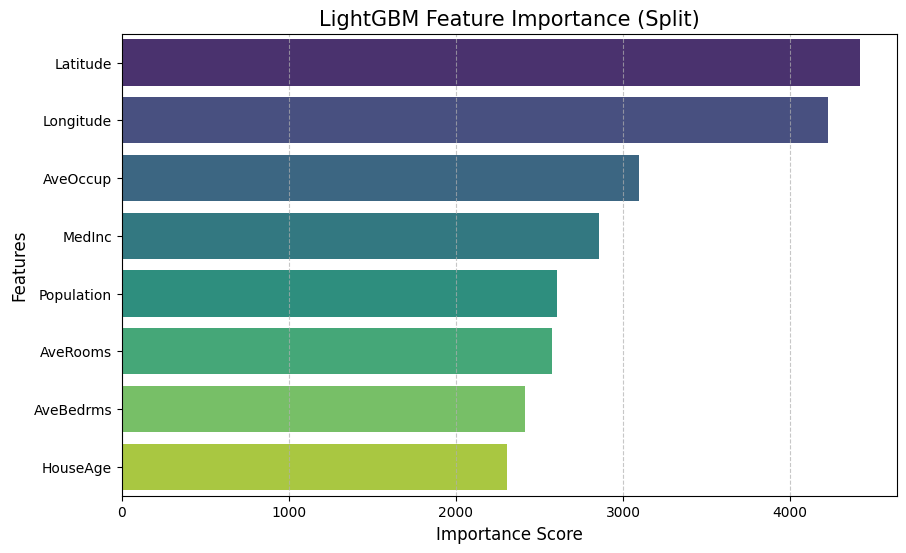

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract the best model from the Random Search Pipeline
# We need to access the 'lgbm' step specifically
best_lgbm_model = random_search.best_estimator_.named_steps['lgbm']

# 2. Get feature names
# Since we used a dataframe X_reg, we can get columns directly
feature_names = X_reg.columns

# 3. Create a DataFrame for Feature Importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_lgbm_model.feature_importances_
})

# 4. Sort by importance to make the chart readable
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 5. Plot using Seaborn for a nice aesthetic
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')

plt.title('LightGBM Feature Importance (Split)', fontsize=15)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Analysis of the Plot

1. MedInc (Median Income): We will likely see this at the very top. In real estate, income is the strongest predictor of house prices.

2. AveOccup (Average Occupancy): Often surprisingly important; density matters in California.

3. Latitude/Longitude: These matter heavily because location is everything in real estate.

# Advanced Interpretability with SHAP
To make this work with our pipeline, we have to be careful. Remember, we used a StandardScaler in our pipeline. This means the LightGBM model learned from scaled numbers (e.g., 0.5 instead of 50,000).

If we feed raw data to the SHAP explainer, the results will be wrong. We must feed it the data exactly as the model sees it.

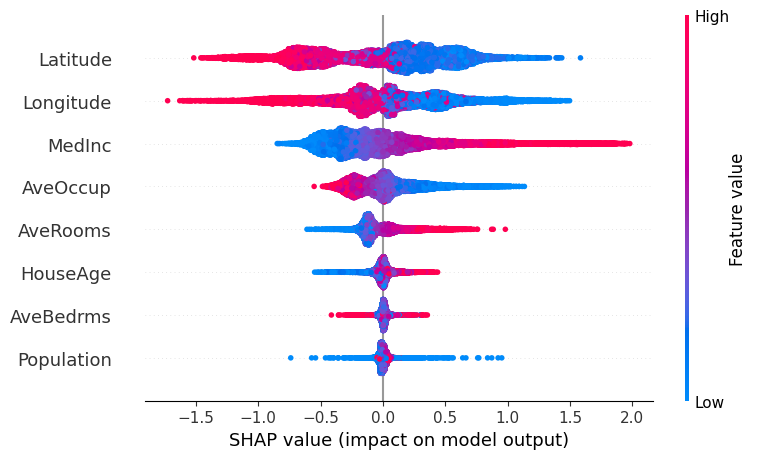

In [4]:
# Step 1: Install & Import

# !pip install shap
import shap

# Initialize JavaScript visualization (needed if running in Jupyter)
shap.initjs()


# Step 2: Prepare the Data for SHAP


# We need to manually apply the scaling step
# from our pipeline to our data so the dimensions match what the model expects.

# 1. Retrieve the steps from our best pipeline
scaler = random_search.best_estimator_.named_steps['scaler']
model = random_search.best_estimator_.named_steps['lgbm']

# 2. Transform our data using the scaler
# The model expects the data to look exactly like the training data (scaled)
X_transformed = scaler.transform(X_reg)

# 3. Create a DataFrame for the transformed data (for nicer labels in plots)
X_transformed_df = pd.DataFrame(X_transformed, columns=X_reg.columns)


# Step 3: Calculate & Plot SHAP Values
# We use the TreeExplainer, which is optimized for tree-based models like LightGBM.

# 1. Create the Explainer
# We pass the trained LightGBM model to it
explainer = shap.TreeExplainer(model)

# 2. Calculate SHAP values
# This calculates the impact of every feature on every single row in our dataset
shap_values = explainer.shap_values(X_transformed_df)

# 3. Generate the Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_transformed_df)

# 📊 Model Interpretation with SHAP

### How to Read the SHAP Beeswarm Plot
The SHAP plot is one of the most information-dense visuals in Data Science. Here is the breakdown of how to interpret it:



* **Y-Axis (Features):** Features are listed in descending order of importance. The top feature is the biggest driver of the model's predictions.
* **X-Axis (SHAP Value):**
    * **Positive values (Right):** The feature pushes the prediction **UP**.
    * **Negative values (Left):** The feature pushes the prediction **DOWN**.
* **Color (Feature Value):**
    * <span style="color:red">**Red:**</span> High value of that feature (e.g., High Income).
    * <span style="color:blue">**Blue:**</span> Low value of that feature (e.g., Low Income).

---

### Example Interpretation: California Housing
1.  **MedInc (Median Income):** We will likely see a long tail of **Red** dots on the far right.
    * **Meaning:** High Income (Red) strongly pushes the house price **UP** (Positive SHAP).
2.  **Latitude:** We might see **Red** dots on the left.
    * **Meaning:** High Latitude (Northern California) pushes the price **DOWN** compared to Southern California.

---

## 📝 Summary Checklist


| Topic | Key Talking Points |
| :--- | :--- |
| **Why LightGBM?** | Faster than XGBoost due to **Leaf-wise growth** (best-first) and **GOSS** (Gradient-based One-Side Sampling). |
| **Trade-offs** | Prone to **overfitting** on small datasets (<1000 rows). Control this via `num_leaves` and `min_data_in_leaf`. |
| **Preprocessing** | Handles **missing values natively** (no imputation needed) and handles categorical features well. Scaling only needed if using linear/distance-based tools in a pipeline. |
| **Tuning** | Don't just tune `n_estimators`. We must balance `num_leaves` (complexity) and `learning_rate` (convergence speed) together. |

# What is SHAP ?

## 🔍 Understanding SHAP (SHapley Additive exPlanations)

SHAP is currently the **"Gold Standard"** method for explaining machine learning models. Here is the breakdown of what it is and why we use it.

---

### 1. The Core Concept: Game Theory
SHAP comes from Game Theory (specifically from Lloyd Shapley, who won a Nobel Prize for this).

* **The Team:** Imagine a group of people (**Features**) working together to generate a result (**The Prediction**).
* **The Contribution:** Some players contribute a lot, some a little, and some actually hurt the team (negative contribution).
* **The Calculation:** SHAP calculates the exact marginal contribution of each "player" to the final score, assuming they could have joined the team in any order.

---

### 2. The Simple Analogy: Buying a House
Let’s say we are predicting the price of a specific house.

* **The Average House Price (Base Value):** $500,000
* **Has a Pool:** Adds value. SHAP: +$30,000
* **50 Years Old:** Reduces value. SHAP: -$20,000
* **Next to a Highway:** Reduces value. SHAP: -$50,000

#### The Calculation:
$$\text{Final Prediction} = \text{Base Value} + \sum (\text{SHAP Values})$$
$$\$460,000 = \$500,000 + (30,000 - 20,000 - 50,000)$$

**What SHAP tells us:** It doesn't just say "Age is important." It tells us "Age lowered the price of **THIS** specific house by exactly $20,000."

---

### 3. Why is it better than "Feature Importance"?



| Feature Importance (LightGBM Built-in) | SHAP Values |
| :--- | :--- |
| **Magnitude Only:** Tells us a feature matters, but not if it's "good" or "bad." | **Directionality:** Tells us if the feature pushes the prediction UP (positive) or DOWN (negative). |
| **Global Only:** Gives an average for the whole dataset. Cannot explain a single row. | **Local & Global:** Explains why one specific row (e.g., a single loan denial) happened, while also aggregating for global insights. |

---

### 4. The "Waterfall" Plot
The most famous way to look at SHAP is the **Waterfall Plot**. It visualizes the transition from the Base Value $\to$ Final Prediction.



```python
# Visualize the first prediction's explanation
# Shows how we get from average price (E[f(x)]) to predicted price (f(x))
shap.plots.waterfall(explainer[0])